In [1]:
import numpy as np
import os,glob,struct,shutil,copy
import xarray as xr
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from parflow import Run, read_pfb, write_pfb, ParflowBinaryReader,read_pfb_sequence

In [3]:
root_dir = "/home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/"
wdir = root_dir+'results/'

In [4]:
""" Read Forcings: """
forcing_headers = {0:'SWin',1:'LWin',2:'P', 3: 'T', 4:'WindX', 5:'WindY',6:'Press', 7:'Hs'}
forc = pd.read_csv(os.sep.join([root_dir,'forc_bani_5min_2006_2009.txt']),header=None,sep=' ')
forc.rename(columns=forcing_headers,inplace=True)
forc.index=pd.date_range('1/1/2006 00:00:00', periods=len(forc), freq='5min')
P=forc['P']*5*60
forc

SWin      LWin    P         T   WindX  WindY    Press  \
2006-01-01 00:00:00  3.7305  316.1700  0.0  291.1000  0.9565    0.0  98450.0   
2006-01-01 00:05:00  3.7260  316.3100  0.0  291.0508  0.9113    0.0  98450.0   
2006-01-01 00:10:00  3.7215  316.4500  0.0  291.0017  0.8660    0.0  98450.0   
2006-01-01 00:15:00  3.7170  316.5900  0.0  290.9525  0.8208    0.0  98450.0   
2006-01-01 00:20:00  3.7125  316.7300  0.0  290.9033  0.7755    0.0  98450.0   
...                     ...       ...  ...       ...     ...    ...      ...   
2009-12-31 23:10:00 -0.2190  318.3567  0.0  292.3033  0.2318    0.0  98750.0   
2009-12-31 23:15:00 -0.2070  318.2350  0.0  292.1475  0.1910    0.0  98750.0   
2009-12-31 23:20:00 -0.1950  318.1133  0.0  291.9917  0.1502    0.0  98750.0   
2009-12-31 23:25:00 -0.1830  317.9917  0.0  291.8358  0.1093    0.0  98750.0   
2009-12-31 23:30:00 -0.1710  317.8700  0.0  291.6800  0.0685    0.0  98750.0   

                         Hs  
2006-01-01 00:00:00  0.0026  
2006-01-01 00:05:00  0.0026  
2006-01-01 00:10:00  0.0026  
2006-01-01 00:15:00  0.0026  
2006-01-01 00:20:00  0.0026  
...                     ...  
2009-12-31 23:10:00  0.0022  
2009-12-31 23:15:00  0.0022  
2009-12-31 23:20:00  0.0022  
2009-12-31 23:25:00  0.0022  
2009-12-31 23:30:00  0.0022  

[420763 rows x 8 columns]

In [5]:
data_evts_file = "/home/hectorb/ADMIN/TEAM/Mahamadi/data/data_BH_1D_2D/evts_banizoumbou_6h_90_21.txt"
data_evts = pd.read_csv(data_evts_file,sep='\t')

In [6]:
data_evts.Starting = data_evts.Starting.apply(lambda x: pd.to_datetime(x))
data_evts.End = data_evts.End.apply(lambda x: pd.to_datetime(x))

In [7]:
subset = data_evts.loc[(data_evts.Volume>15) & (data_evts.Volume<20) & \
              (data_evts.Starting.dt.year>2006) & (data_evts.Starting.dt.year<2009) &\
              (data_evts.Duration>2.5) & (data_evts.Duration<4.5),:]
subset

Starting                 End  Duration  Volume  Intensity
685 2007-07-23 11:30:00 2007-07-23 14:00:00       3.0   19.46   6.486667
696 2007-08-23 06:30:00 2007-08-23 10:00:00       4.0   19.89   4.972500

In [8]:
# avec:
#pevent = P.loc[(P.index>= subset.Starting.iloc[0]+pd.Timedelta(minutes=10)) & \
#      (P.index<= (subset.End.iloc[0]+pd.Timedelta(minutes=25)))]

#=> Jusqu'à 50% d'erreur de bilan avec un pdt de 25 ou 30mn. Sans doute pb de post processing

pevent = P.loc[(P.index>= subset.Starting.iloc[0]-pd.Timedelta(minutes=20)) & \
      (P.index<= (subset.End.iloc[0]+pd.Timedelta(minutes=25)))]

In [9]:
pevent

2007-07-23 11:10:00    0.00
2007-07-23 11:15:00    0.00
2007-07-23 11:20:00    0.00
2007-07-23 11:25:00    0.00
2007-07-23 11:30:00    0.00
2007-07-23 11:35:00    0.00
2007-07-23 11:40:00    0.00
2007-07-23 11:45:00    2.28
2007-07-23 11:50:00    6.06
2007-07-23 11:55:00    4.08
2007-07-23 12:00:00    0.66
2007-07-23 12:05:00    0.75
2007-07-23 12:10:00    0.87
2007-07-23 12:15:00    0.42
2007-07-23 12:20:00    0.27
2007-07-23 12:25:00    0.24
2007-07-23 12:30:00    0.18
2007-07-23 12:35:00    0.18
2007-07-23 12:40:00    0.18
2007-07-23 12:45:00    0.18
2007-07-23 12:50:00    0.18
2007-07-23 12:55:00    0.21
2007-07-23 13:00:00    0.21
2007-07-23 13:05:00    0.24
2007-07-23 13:10:00    0.24
2007-07-23 13:15:00    0.18
2007-07-23 13:20:00    0.15
2007-07-23 13:25:00    0.15
2007-07-23 13:30:00    0.12
2007-07-23 13:35:00    0.12
2007-07-23 13:40:00    0.12
2007-07-23 13:45:00    0.12
2007-07-23 13:50:00    0.12
2007-07-23 13:55:00    0.15
2007-07-23 14:00:00    0.15
2007-07-23 14:05:00 

In [10]:
vol = pevent.sum()
print(vol)

19.409999999999997


## Some Functions

In [11]:
def load_convert_and_run_simulation(simuname,tstep,ntstep,forcing_event,root_dir,N,alpha,manning):
    sim = Run.from_definition(simuname)
    sim.TimingInfo.StopTime = ntstep*tstep
    sim.Cycle.rain.Names = ' '.join('_%d'%i for i in range(ntstep))
    for i in range(ntstep):
        sim.Cycle.rain['_%d'%i].Length = tstep
    sim.Patch.z_upper.BCPressure.Cycle = 'rain'
    sim.TimeStep.Value = tstep
    sim.TimingInfo.DumpInterval = tstep
    
    #how much the relative reduction in the nonlinear residual should
    #be before nonlinear iterations stop. 
    #The magnitude of the residual is measured with the l 1 (max) norm.
    sim.Solver.Nonlinear.ResidualTol = 1e-13
    
    #This value gives the absolute tolerance for the linear solve algorithm.
    sim.Solver.AbsTol = 1e-8
    
    #This key specifies how the linear system tolerance will be selected. The linear system is solved until a relative
#residual reduction of η is achieved. Linear residuall norms are measured in the l 2 norm. Choices for this key include
#EtaConstant, Walker1 and Walker2. If the choice EtaConstant is specified, then η will be taken as constant.
#The choices Walker1 and Walker2 specify choices for η developed by Eisenstat and Walker [32]. The choice
#Walker1 specifies that η will be given by |kF (u k )k − kF (u k−1 ) + J(u k−1 ) ∗ pk|/kF (u k−1 )k. The choice Walker2
#specifies that η will be given by γkF (u k )k/kF (u k−1 )k α . For both of the last two choices, η is never allowed to be less
#than 1e-4.
    sim.Solver.Nonlinear.EtaChoice = "Walker2"
    sim.Solver.Nonlinear.EtaAlpha = 0.0001
    sim.Solver.Nonlinear.EtaGamma = 0.0001

    
    #sim.Solver.Nonlinear.EtaValue = 1e-7
    
    
    sim.Solver.Nonlinear.MaxIter = 50
    #the tolerance that measures how small the difference between two consecutive nonlinear steps
    #can be before nonlinear iterations stop
    # when reached, it crashes
    #sim.Solver.Nonlinear.StepTol = 1e-10

    sim.Geom.H2.Saturation.N = N
    sim.Geom.H3.Saturation.N = N
    sim.Geom.H2.RelPerm.N = N
    sim.Geom.H3.RelPerm.N = N    
    
    sim.Geom.H2.Saturation.Alpha = alpha
    sim.Geom.H3.Saturation.Alpha = alpha
    sim.Geom.H2.RelPerm.Alpha = alpha
    sim.Geom.H3.RelPerm.Alpha = alpha    
        
    
    for i in range(ntstep):
        sim.Patch.z_upper.BCPressure['_%d'%i].Value = -forcing_event.iloc[i]/1000    
    sim.Mannings.Geom.domain.Value = manning     
    wdir = root_dir+'results/'
    if os.path.exists(wdir):
        shutil.rmtree(wdir)
    os.mkdir(wdir)        
    
    shutil.copy(root_dir+'slopey.pfb',wdir+'slopey.pfb')
    shutil.copy(root_dir+'perm1s.pfb',wdir+'perm1s.pfb')
    #hill.ComputationalGrid.NZ = 1
    sim.dist(wdir+'slopey.pfb')
    #hill.ComputationalGrid.NZ = 30
    sim.dist(wdir+'perm1s.pfb')
    sim.run(working_directory=wdir,skip_validation=False)

In [12]:
def read_and_process_pf_outputs(wdir,date_start="2005-01-01",freq='h'):
    # read header
    with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
    print(h)
    
    # get z
    var_dz = read_pfb(glob.glob(wdir+'*mult*.pfb')[0])
    var_dz_vec = var_dz[:,0,0]
    var_dz_vec = var_dz_vec[::-1]
    dz = var_dz_vec * h['dz']
    z = np.cumsum(dz) - var_dz_vec* h['dz']/2 
    
    # get pressure (pop(0) skips initial condition)
    files = np.sort(glob.glob(wdir+'*.press.*.pfb'))[1::]
    press = read_pfb_sequence(files)
    
    # get saturation
    files = np.sort(glob.glob(wdir+'*.satur.*.pfb'))[1::]
    satur = read_pfb_sequence(files)
    
    # get overlandsum
    files = np.sort(glob.glob(wdir+'*.overlandsum.*.pfb'))
    overlandsum = read_pfb_sequence(files)
        
    # create dataset
    ds = xr.Dataset({"press": (("time","z","y"), press[:,::-1,:,0]),
                    "satur": (("time","z","y"), satur[:,::-1,:,0]),
                    "overlandsum":(("time","y"), overlandsum[:,0,:,0]),
                    'vdz': (("z","y"),var_dz[::-1,:,0])},
        coords={"x":np.arange(start = h['x'],stop = h['x']+h['nx']*h['dx'],step=h['dx']),
            "y":np.arange(start = h['y'],stop = h['y']+h['ny']*h['dy'],step=h['dy']),
            "z":-z, 
            "time": pd.date_range(date_start, periods=len(files),freq=freq),
            "reference_time": pd.Timestamp(date_start)})

    # add WTD:
    ds = ds.assign(WTD = z[-1] - ds.press.isel(z=-1))

    # add auxiliary variables:
    ds = ds.assign(poro=(("z","y"),read_pfb(glob.glob(wdir+'*poro*.pfb')[0])[::-1,:,0]))
    ds = ds.assign(specstor=(("z","y"),read_pfb(glob.glob(wdir+'*specific*.pfb')[0])[::-1,:,0]))    

    # compute storage:
    ds = ds.assign(storage_cbyc=lambda x: h['dx']*h['dy']*h['dz']*x.satur*x.vdz*x.poro + \
                                        h['dx']*h['dy']*h['dz']*x.vdz*x.specstor*x.satur*x.press + \
                                        xr.where((x.z==x.z[0]) & (x.press>0),h['dx']*h['dy']*x.press,0))
    ds = ds.assign(storage=lambda x: x.storage_cbyc.sum(dim=('z')))

    ds = ds.assign(storage_mm=lambda x: x.storage*1000/h['dx']/h['dy']/h['ny'])
    
    ds = ds.assign(soil_moisture = lambda x: x.satur*x.poro)
    
    ds.press.attrs['units']='m'
    ds.satur.attrs['units']='m3/m3'
    ds.overlandsum.attrs['units']='m3/PFtimestep' 
    ds.storage.attrs['units']='m3'
    ds.storage_cbyc.attrs['units']='m3'  
    ds.storage_mm.attrs['units']='mm'    
    ds.y.attrs['units']='meters'
    ds.z.attrs['units']='meters'
    return ds

In [13]:
def calculate_OVFLOW(width,manning,slope,h):
    """
    simple function which return the overland flux from one cell to another across one cell
    """
    return (width/manning)*(slope**0.5)*h**(5./3.)


def calculate_runoff_from_press(htop,slopex,slopey,dx,dy,m):
    """
    compute runoff at single location
    htop dim is time
    """
    Sy = np.abs(slopey)
    Sx = np.abs(slopex)
    return np.where(htop>0,np.abs(calculate_OVFLOW(dy,m,Sx,htop))+np.abs(calculate_OVFLOW(dx,m,Sy,htop)),0)


In [14]:
def read_outputs(wdir,date_start,freq,manning):
    ds1 = copy.deepcopy(read_and_process_pf_outputs(wdir,date_start=date_start,freq=freq))
    with ParflowBinaryReader(glob.glob(wdir+'*.press.0000000.pfb')[0]) as s: h = s.header
    h['dx']
    ds1 = ds1.assign(slopex=(("y"),read_pfb(glob.glob(wdir+'*slope_x*.pfb')[0])[0,:,0]))
    ds1 = ds1.assign(slopey=(("y"),read_pfb(glob.glob(wdir+'*slope_y*.pfb')[0])[0,:,0]))
    ds1 = ds1.assign(mask=(("z","y","x"),read_pfb(glob.glob(wdir+'*mask*.pfb')[0])))
    ds1 = ds1.assign(Q=lambda x: ('time',calculate_runoff_from_press(x.press.data[:,0,0],
                                                         x.slopex.data[0],
                                                         x.slopey.data[0],
                                                         h['dx'],h['dy'],manning)))
    ds1.Q.attrs['units']='m3/s'
    ds1 = ds1.assign(Qmm = lambda x: x.Q/h['dx']/h['nx']/h['dy']/h['ny']*1000)
    return ds1

In [15]:
freq_str='1s'
if 's' in freq_str:
    print('ok')

ok


In [16]:
if freq_str in ['10s']:
    print('ok')

In [17]:
int(freq_str.split('s')[0])

1

In [18]:
def create_forcing_ts(base_forcing,scale_factor,freq_str,original_tstep_second,tstep):

    #check tstep and freq_str are coherent:
    if 's' in freq_str:
        tstep_from_freq = int(freq_str.split('s')[0])
    elif 'min' in freq_str:
        tstep_from_freq = int(freq_str.split('min')[0])
    if tstep_from_freq != tstep:
        print('error in tstep vs. freq_str, should match')
    #Interpolate forcing at freq_str and switch from mm/5mn to mm/freq_unit
    # or, if freq_str is at lower resolution than original_tstep_second, aggregate cumulative values
    
    if 's' in freq_str:
        new_forcing = base_forcing.resample(freq_str).interpolate('linear')/original_tstep_second
        # this divides by 60 x 5 seconds
        
    elif 'min' in freq_str:
    
        if tstep_from_freq<=original_tstep_second/60.:
            new_forcing = base_forcing.resample(freq_str).interpolate('linear')/original_tstep_second*60.
            # this divides by 5 minutes

        else:
            new_forcing = base_forcing.resample(freq_str).sum()/tstep
    
    else: 
        print('error freq_str can only be s or min')
    return new_forcing*scale_factor

In [19]:
def run_and_analyse_single_simulation(base_forcing,scale_factor,freq_str,original_tstep_second,tstep,root_dir,simname,N,alpha,KsH2=0.01,base_manning = 0.0000056):
    """Ks H2 in m/h"""
    
    new_forcing = create_forcing_ts(base_forcing,scale_factor,freq_str,original_tstep_second,tstep)

    ntstep = new_forcing.size
    
    
    ## Update Ks in s or min, as well as manning:
    
    with ParflowBinaryReader(root_dir+'perm1.pfb') as pfb:
        data = pfb.read_all_subgrids()
        hdr = pfb.read_header()
        
    if 's' in freq_str:
        data = data/3600
        data[-11:-5,:,:] = KsH2/3600
        #manning = base_manning/3600.
        #corrected on the 6th may 2024:
        manning = base_manning*3600.
    elif 'min' in freq_str:
        data = data/60
        data[-11:-5,:,:] = KsH2/60
        #manning = base_manning/60.     
        #corrected on the 6th may 2024:
        manning = base_manning*60.
    write_pfb(root_dir+'perm1s.pfb',data,**hdr)
    
    ## run parflow
    load_convert_and_run_simulation(simname,tstep,ntstep,new_forcing,root_dir,N,alpha,manning)
    ds = read_outputs(wdir,date_start= new_forcing.index[0],freq=freq_str,manning = manning)    

    
    vol = new_forcing.sum()*tstep
    
    # Q
    Qtot = (ds.Qmm*tstep).sum().data
    # Budg
    storage = ds.storage_mm.sum(dim='y').to_dataframe()['storage_mm']
    storage = storage - storage[0]
    budg_res = vol-storage[-1]-Qtot   
    Ke = 100*Qtot/vol
    print("freq = %s, Ke = %2.2f %%"%(freq_str,Ke))
    return [pd.DataFrame(data = {'total_precip (mm)':[vol],
                                'Le (mm)': [Qtot], 'Ke (%)': [Ke],
                               'budg (mm)':[budg_res],
                                'budg (%)':[100*budg_res/vol]}, index=[freq_str]),
            (ds.Qmm.to_dataframe()['Qmm']*tstep)]

In [20]:
simname = root_dir+'SA_mil_1.pfidb'

In [21]:

list_t_resolution = {'30s':30,'1min':1,'5min':5}
#N=[1.7,2,2.3,2.6,3,3.3]
N=[1.5,1.9,2.3,2.6,3.3]

#Alpha = [1,2,3,4,5,6,7]
Alpha = [1,5,9]

# rainf event = 20mm... try 2mm, 4mm, 8mm, 12mm, 20mm, 30mm 
rainf_volume_scale_factor = [0.1,0.2,0.4,0.6,1,1.5,2]

#list_t_resolution = {'2min':2,'5min':5,
#                     '8min':8,'10min':10,'12min':12,'15min':15,'18min':18,
#                     '20min':20,'25min':25,'30min':30}
Qrscale = dict()
for rscale in rainf_volume_scale_factor:
    QA = dict()
    for a in Alpha:
        QN = dict()
        for n in N:
            results=pd.DataFrame()
            Qt = dict()
            for key,val in list_t_resolution.items():
                [r,q] = run_and_analyse_single_simulation(pevent,rscale,key,60*5,val,root_dir,simname,n,a)
                r.loc[key,'N'] = n
                r.loc[key,'Alpha'] = a
                results = pd.concat([results,r])    
                Qt[key] = q
            QN[n]=[Qt,results]
        QA[a]=QN
    Qrscale[rscale]=QA



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 1min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.01 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.02 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.16 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.07 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.10 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.13 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.49 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.28 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.33 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.81 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.76 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.82 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.41 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 1.34 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 1.41 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.15 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 1.58 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 1.65 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.47 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 2.17 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 2.22 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.08 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 2.55 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 2.60 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.46 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 3.22 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 3.26 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.05 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 2.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 2.90 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.81 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 3.59 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 3.65 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.66 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 4.54 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 4.63 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.64 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 5.12 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 5.19 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 6.21 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 6.06 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 6.15 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.05 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 2.06 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 2.11 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.85 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 1.01 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 1.05 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.81 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.86 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.91 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.69 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.87 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.91 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.70 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 0.96 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 0.98 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.79 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 7.79 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 7.95 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.43 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 7.26 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 7.38 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.80 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 7.89 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 8.03 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.31 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 8.35 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 8.48 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.64 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 9.10 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 9.22 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.13 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 12.51 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 12.65 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.15 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 12.35 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 12.54 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.93 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 13.62 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 13.75 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.85 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 14.43 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 14.58 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.35 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 15.66 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 15.81 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.03 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 6.07 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 6.16 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.42 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 4.04 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 4.07 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.98 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 3.71 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 3.73 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.60 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 3.67 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 3.68 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.54 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 3.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 3.74 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.53 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 20.42 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 20.50 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.21 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 17.34 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 17.44 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.20 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 17.54 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 17.67 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.08 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 17.89 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 1min, Ke = 18.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.16 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 18.49 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 18.53 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.57 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 27.40 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 27.43 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 27.83 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 25.98 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 26.04 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.00 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 26.69 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 26.71 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.60 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 27.20 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 27.20 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 27.05 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


freq = 30s, Ke = 28.03 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 1min, Ke = 28.04 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 27.72 %


/tmp/ipykernel_17140/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


In [22]:
def return_seconds(freq_str):
    if 's' in freq_str:
        tstep = float(freq_str.split('s')[0])
    elif 'min' in freq_str:
        tstep = float(freq_str.split('min')[0])*60
    return tstep


In [23]:
#results['tstep'] = [return_seconds(x) for x in results.index]
#results

In [24]:
Qrscale[0.4][5][1.7][1]

KeyError: 1.7

In [25]:
from sklearn.metrics import mean_squared_error
# Define a custom model function with two parameters
def custom_model(params, X):
    pente, seuil = params
    return np.where(X>=seuil,pente * X -seuil*pente,0)

# Define a loss function to minimize (e.g., mean squared error)
def loss_function(params, X, y):
    y_pred = custom_model(params, X)
    return mean_squared_error(y, y_pred)

In [26]:
Qtemp = pd.DataFrame(columns=list_t_resolution.keys())

In [27]:
Qtemp

Empty DataFrame
Columns: [30s, 1min, 5min]
Index: []

In [28]:
alpha = 9
n = 3.3
for rscale in rainf_volume_scale_factor:
    for key,val in list_t_resolution.items():
        totP = np.round(1000*Qrscale[rscale][alpha][n][1].loc[key,'total_precip (mm)'])/1000
        Qtemp.loc[totP,key] = Qrscale[rscale][alpha][n][1].loc[key,'Le (mm)']

In [29]:
Qtemp

30s                 1min                 5min
1.941                   0.0                  0.0                  0.0
3.882                   0.0                  0.0                  0.0
7.764                   0.0                  0.0                  0.0
11.646  0.08824922311276416  0.09498578516448046  0.16442124051822526
19.410   1.1764459316990197   1.1928237104515376    1.368000557999783
29.115    4.557981882656496    4.603601914906631    4.666163238596337
38.820   10.881822091159734   10.883253901700218   10.760863948782617

In [30]:
Kefit = pd.DataFrame(columns=list_t_resolution.keys())
# Initial guess for the parameters
initial_params = [0.2, 9]
# Fit the model parameters to the data using optimization
from scipy.optimize import minimize
for key,val in list_t_resolution.items():
    result = minimize(loss_function, initial_params, args=(Qtemp.index,Qtemp.loc[:,key]))
    Kefit.loc['pente',key] = result.x[0]
    Kefit.loc['seuil',key] = result.x[1]


In [31]:

# Plot the data and the fitted model
for key,val in list_t_resolution.items():
    plt.scatter(Qtemp.index,Qtemp.loc[:,key], label=key)
plt.xlabel('P (mm)')
plt.ylabel('Lame d eau (mm)')

# Plot the fitted model
for key,val in list_t_resolution.items():
    X_range = np.linspace(min(Qtemp.index), max(Qtemp.index), 100)
    y_pred = custom_model(Kefit.loc[:,key], X_range)
    plt.plot(X_range, y_pred, color='k', label='Fit %s: seuil: %2.2f mm, pente: %2.1f %%'%(key,Kefit.loc['seuil',key],Kefit.loc['pente',key]*100))
plt.legend()
# Calculate and print performance metrics
#mse = mean_squared_error(Q_P, custom_model(optimized_params, Q_P.index))

#print("seuil: %2.2f mm"%optimized_params[1])
#print("pente: %2.1f %%"%(optimized_params[0]*100))


#print("Mean Squared Error:%2.2f"%mse)
#plt.savefig(root_dir+'sens_time_resolution_on_KEfits_n3_3_and_alpha9.png')
# after manning correction 6/05/24
plt.savefig(root_dir+'sens_time_resolution_on_KEfits_n3_3_and_alpha9_manncorr.png')

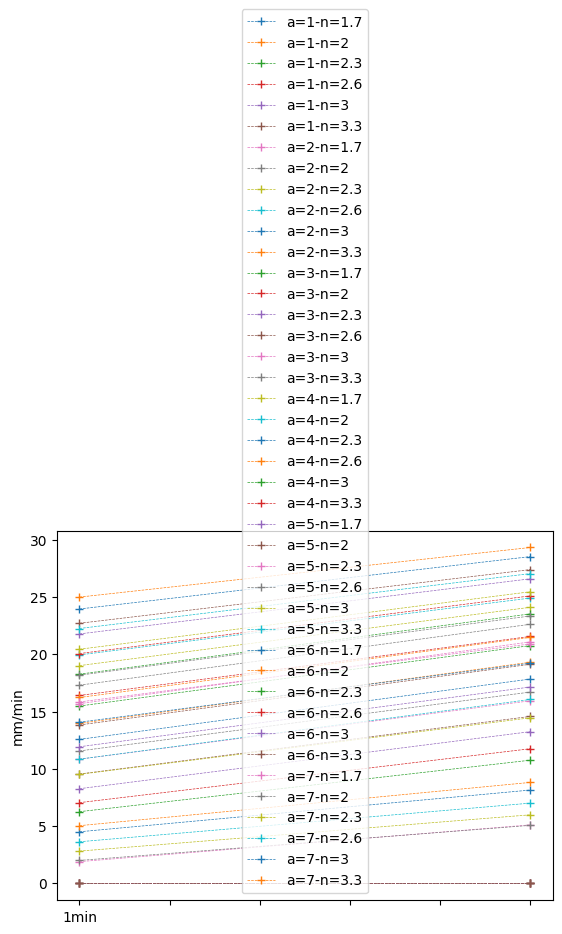

In [26]:
for alpha,v1 in QA.items():
    for n,v2 in v1.items():
        v2[1].iloc[:,2].plot(label='a=%s-n=%s'%(alpha,n),style='+--',lw=0.5)
        plt.gca().set_ylabel('mm/min')
plt.legend()


In [27]:
results = pd.DataFrame(columns=['Alpha','N','Ke'])
k=0
for alpha,v1 in QA.items():
    for n,v2 in v1.items():
        results.loc[k]=pd.Series({'Ke':v2[1].iloc[1,2],'Alpha':alpha,'N':n})
        k+=1

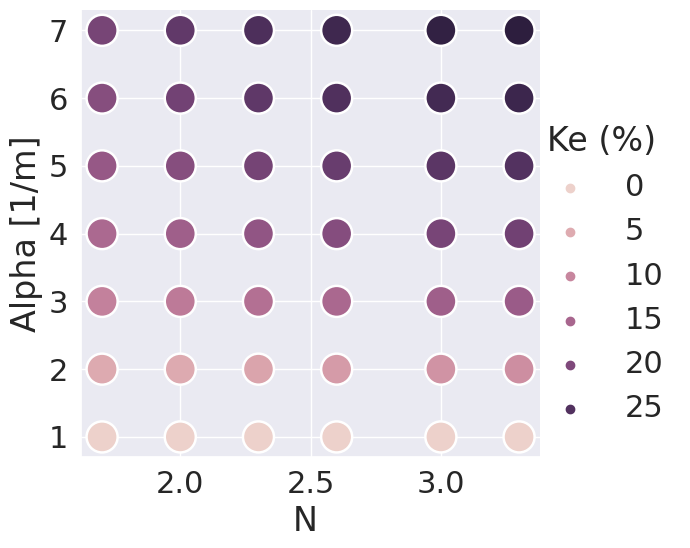

In [28]:
import seaborn as sns
#np.set_printoptions(precision=2)
sns.set(font_scale=2)
splot = sns.relplot(x="N", y="Alpha",hue='Ke',s=500, data=results,height=6,aspect=1)
#t = splot._legend.get_texts()
splot.set(ylabel="Alpha [1/m]")
splot.set(xlabel="N ")
tt = splot._legend.get_title()
tt.set_text('Ke (%)')


In [29]:
Ks = 5*np.logspace(start = -3, stop = -1.5, num=10, base=10)

In [30]:
Ks

array([0.005     , 0.007339  , 0.01077217, 0.01581139, 0.02320794,
       0.0340646 , 0.05      , 0.07338996, 0.10772173, 0.15811388])

In [31]:
Ks/3600

array([1.38888889e-06, 2.03861009e-06, 2.99227040e-06, 4.39205231e-06,
       6.44665116e-06, 9.46238985e-06, 1.38888889e-05, 2.03861009e-05,
       2.99227040e-05, 4.39205231e-05])

In [32]:
N=[1.7,2,2.3,2.6,3,3.3]
Alpha = [1,2,3,4,5,6,7]
KsH2 = 5*np.logspace(start = -3, stop = -1.5, num=10, base=10)
#list_t_resolution = {'2min':2,'5min':5,
#                     '8min':8,'10min':10,'12min':12,'15min':15,'18min':18,
#                     '20min':20,'25min':25,'30min':30}
results = pd.DataFrame(columns=['Alpha','N','KsH2','Ke'])
freq = '5min'
k=0
QA = dict()
for a in Alpha:
    QN = dict()
    for n in N:
        Qks = dict()
        for ks in KsH2:
            [r,q] = run_and_analyse_single_simulation(pevent,freq,60*5,5,root_dir,simname,n,a,ks)
            Qt = dict()
            results.loc[k]=pd.Series({'Ke':r.loc[freq,'Ke (%)'],'Alpha':a,'N':n,'KsH2':ks})
            k+=1
            Qks[ks]=[r,q]
        QN[n]=Qks
    QA[a]=QN



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.72 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.94 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.18 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.63 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.25 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.66 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.21 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.31 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.84 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.48 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.28 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.41 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.83 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.43 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.44 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.02 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.35 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.76 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.36 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.44 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.01 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.38 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.77 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 6.38 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.39 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.99 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.76 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.52 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.90 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.53 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.50 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.05 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.85 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.18 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.56 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.20 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.18 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.66 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.50 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.49 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.62 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.98 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.03 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.24 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.60 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.12 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.77 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.77 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.04 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.05 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.24 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.63 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 6.23 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.01 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.16 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.24 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.39 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 0.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.51 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.52 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.74 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.18 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.86 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.75 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.83 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.81 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.03 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.28 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.83 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.07 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.56 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.31 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.28 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.46 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.13 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.41 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.16 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.18 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.44 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.98 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.79 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.85 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.13 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.61 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.80 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.19 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.91 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.94 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.21 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.77 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.62 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.07 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 6.61 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.58 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.02 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.08 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.46 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.01 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.61 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.62 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.91 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 2.12 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 1.02 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.69 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.05 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.61 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.38 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.35 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.49 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.75 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 6.11 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.53 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 3.08 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.43 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.81 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.41 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.23 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.28 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.52 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.91 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.41 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 6.99 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 5.62 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.86 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.26 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.88 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.75 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.86 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.18 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.67 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.28 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.99 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.75 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.27 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.69 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.34 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.25 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.42 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.40 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.13 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.96 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.86 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.05 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.48 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.14 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.08 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.28 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.36 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.16 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.06 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.03 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.36 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.96 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.74 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.71 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.84 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.10 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.47 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.89 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 6.33 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 4.76 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.31 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.92 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.74 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.76 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.98 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.37 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.88 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.48 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.12 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 7.78 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.20 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.84 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.70 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.78 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.08 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.56 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.19 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.92 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.71 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.53 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.69 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.36 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.25 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.37 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.28 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.00 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.68 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.13 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.74 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.91 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.32 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.94 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.74 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.67 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.68 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.75 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.92 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.61 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.55 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.74 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.18 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.85 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.69 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.67 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.75 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.89 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.13 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.91 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.86 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.31 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.76 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.31 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.92 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 9.55 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hill

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 8.17 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.33 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.12 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.12 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.33 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.73 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.30 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.99 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.76 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.58 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 11.41 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 27.31 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.14 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.18 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.45 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.93 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.59 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.39 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.28 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.23 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.21 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.82 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.68 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.76 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.08 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.61 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.34 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.21 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.19 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.25 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.34 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 30.26 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.15 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.26 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.61 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.20 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.99 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.94 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.01 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.16 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.36 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 31.04 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.94 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 27.07 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.44 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.06 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.89 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.88 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.00 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.20 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.46 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.57 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.48 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.57 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.85 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.30 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.89 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.57 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 13.32 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 12.10 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 10.86 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.94 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.88 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.02 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.37 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.91 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.62 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.44 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 16.35 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 15.30 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 14.26 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.97 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.95 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.14 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.56 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.17 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.96 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.89 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 18.91 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.98 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 17.08 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 30.50 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.51 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.74 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.19 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.86 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.71 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.71 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 20.81 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.98 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 19.18 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 31.93 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 29.97 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 28.23 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.72 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.44 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.35 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.42 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.60 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.85 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 21.15 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 32.70 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 30.75 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 29.03 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hil

/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 27.54 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 26.29 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 25.24 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 24.34 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 23.56 %

# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================



/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.86 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)



# ==============================================================================
# ParFlow directory
#  - /home/hectorb/PARFLOW/SOURCES/PF_test/parflow
# ParFlow version
#  - 3.3.1
# Working directory
#  - /home/hectorb/PARFLOW/PROJECTS/Hillslope/tondi/mahamadi/res_t/results
# ParFlow database
#  - SA_mil_1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================

{'x': 0.0, 'y': 0.0, 'z': 0.0, 'nx': 1, 'ny': 32, 'nz': 30, 'dx': 100.0, 'dy': 25.0, 'dz': 1.0, 'n_subgrids': 1, 'p': 1, 'q': 1, 'r': 1}
freq = 5min, Ke = 22.22 %


/tmp/ipykernel_524800/3031432411.py:5: RuntimeWarning: invalid value encountered in power
  return (width/manning)*(slope**0.5)*h**(5./3.)


In [33]:
results

Alpha    N      KsH2         Ke
0      1.0  1.7  0.005000   2.717773
1      1.0  1.7  0.007339   0.000000
2      1.0  1.7  0.010772   0.000000
3      1.0  1.7  0.015811   0.000000
4      1.0  1.7  0.023208   0.000000
..     ...  ...       ...        ...
415    7.0  3.3  0.034065  25.235281
416    7.0  3.3  0.050000  24.339308
417    7.0  3.3  0.073390  23.561262
418    7.0  3.3  0.107722  22.863819
419    7.0  3.3  0.158114  22.216015

[420 rows x 4 columns]

In [34]:
sns.pairplot(results)

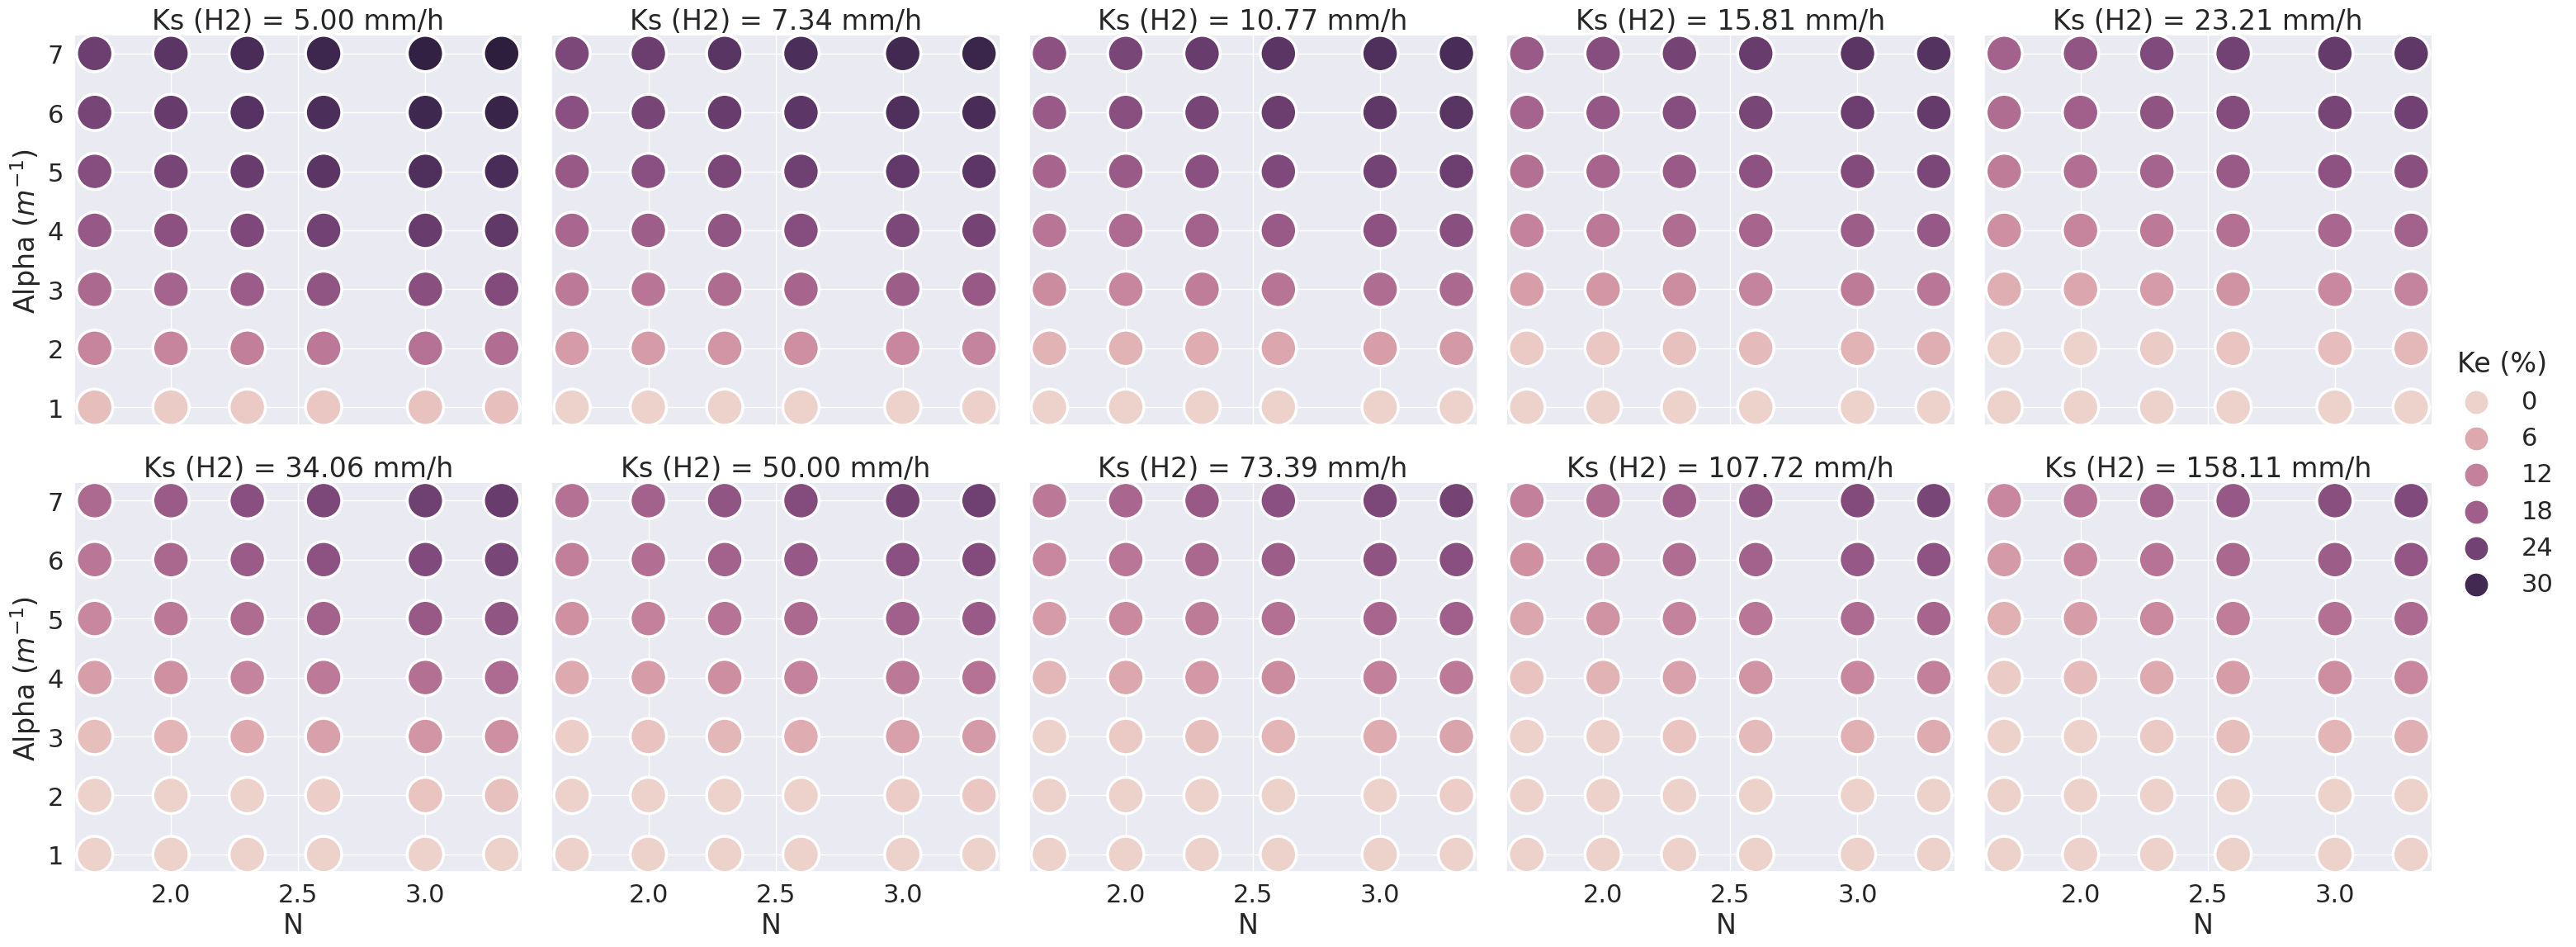

In [35]:

from matplotlib.colors import LogNorm
sns.set(font_scale=2)
splot = sns.relplot(x="N", y="Alpha",hue='Ke',col="KsH2", col_wrap=5,s=1000, data=results,height=6,aspect=1)
#t = splot._legend.get_texts()
splot.set(ylabel="Alpha ($m^{-1}$)")
splot.set(xlabel="N ")
tt = splot._legend.get_title()
tt.set_text('Ke (%)')

for a in splot.axes.flatten():
    tit = a.get_title()
    a.set_title("Ks (H2) = %2.2f mm/h"%(float(tit.split('= ')[1])*1000))
    
# change legend dots size:
leg = splot._legend
handles = leg.legendHandles
for dot in handles:
    dot.set_sizes(dot.get_sizes() * 10)

#plt.savefig(root_dir+'sensH2_n_alpha_Ks_5min.png')

In [36]:
from matplotlib.colors import LogNorm
sns.set(font_scale=2)
#splot = sns.relplot(x="N", y="Alpha",hue='Ke',size='KsH2',sizes=(50,500), data=results,height=6,aspect=1)
#splot = sns.relplot(x="N", y="Ke",hue='KsH2',hue_norm=LogNorm(),size='Alpha',sizes=(50,500), data=results,height=6,aspect=1)
splot = sns.relplot(x="N", y="Ke",hue='Alpha',size='KsH2',sizes=(50,500), data=results,height=6,aspect=1)

#t = splot._legend.get_texts()
splot.set(ylabel="Alpha [1/m]")
splot.set(xlabel="N ")
tt = splot._legend.get_title()
tt.set_text('Ke (%)')
